In [1]:
import pandas as pd
import numpy as np
import copy
import json

gradcpt_data = pd.read_csv(f'data/res/all_subjects_gradcpt.csv')

In [2]:
gradcpt_data.head()

,Timestamp,Zone,Smoothed VTC,Mountain,Button pressed,Trial,Subject
0,1.711973e+09,0,0.708892,False,True,1,2
1,1.711973e+09,0,0.711862,False,True,1,2
2,1.711973e+09,0,0.719787,False,True,1,2
3,1.711973e+09,0,0.735721,False,True,1,2
4,1.711973e+09,0,0.762475,False,True,1,2


### Add omissions and lapses 

In [3]:
# Create a single column with categorical labels
conditions = [
    (gradcpt_data['Mountain'] & gradcpt_data['Button pressed']),
    (~gradcpt_data['Mountain'] & ~gradcpt_data['Button pressed']),
    (gradcpt_data['Mountain'] & ~gradcpt_data['Button pressed']),
    (~gradcpt_data['Mountain'] & gradcpt_data['Button pressed'])
]
choices = ['Lapse', 'Omission', 'Correct', 'Baseline']
gradcpt_data['Condition'] = np.select(conditions, choices)

In [4]:
gradcpt_data.head()

,Timestamp,Zone,Smoothed VTC,Mountain,Button pressed,Trial,Subject,Condition
0,1.711973e+09,0,0.708892,False,True,1,2,Baseline
1,1.711973e+09,0,0.711862,False,True,1,2,Baseline
2,1.711973e+09,0,0.719787,False,True,1,2,Baseline
3,1.711973e+09,0,0.735721,False,True,1,2,Baseline
4,1.711973e+09,0,0.762475,False,True,1,2,Baseline


### plot VTC

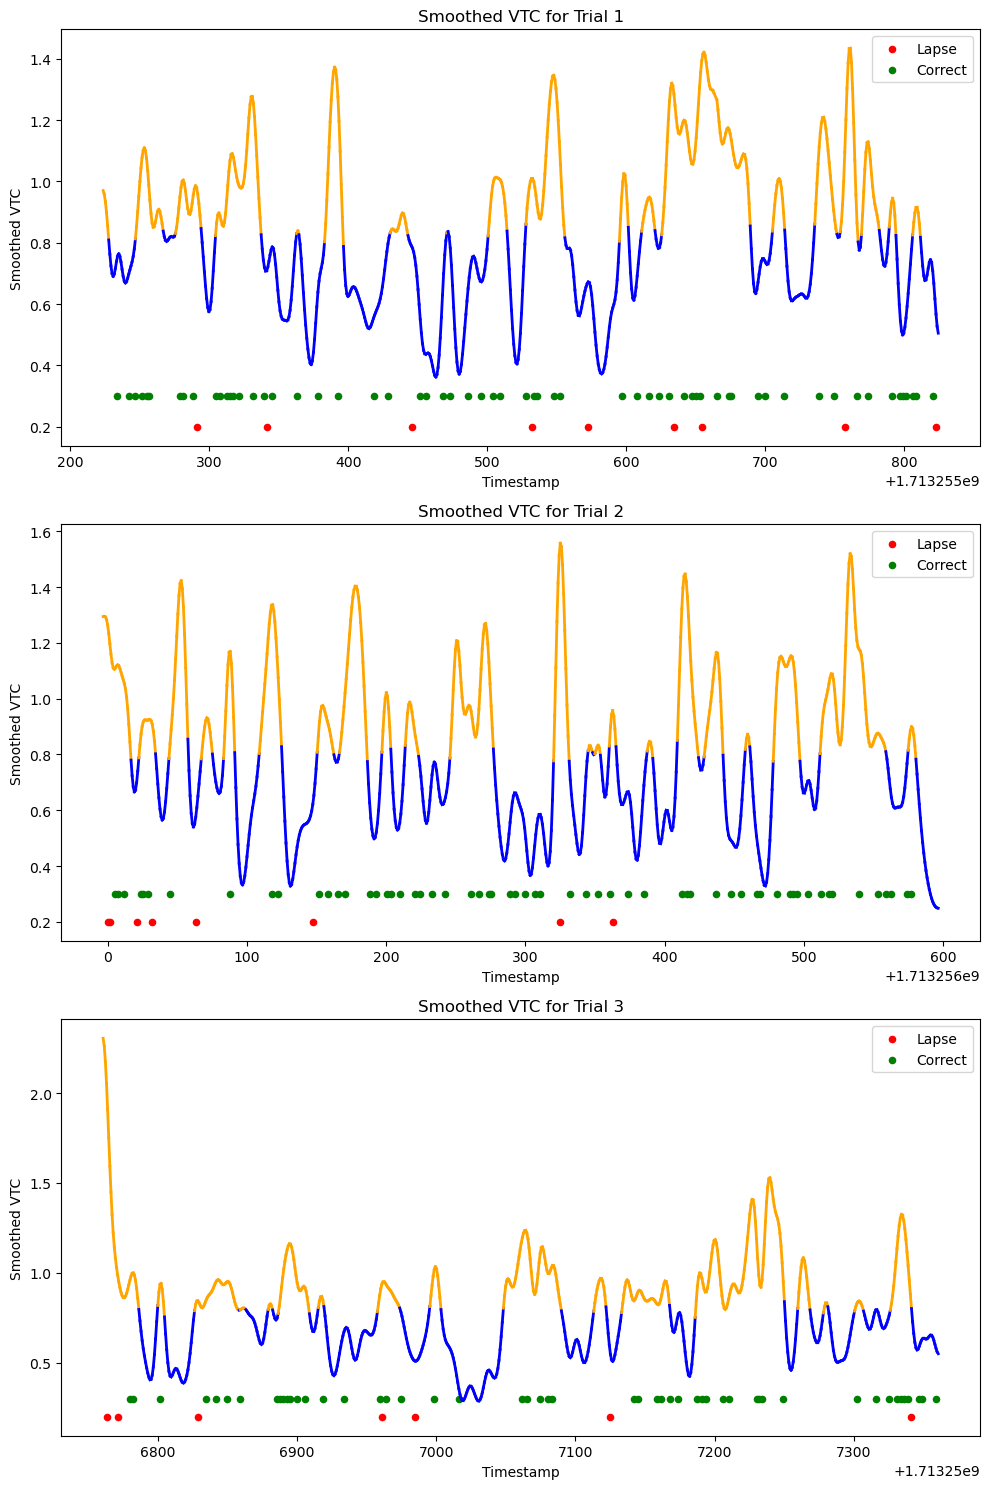

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gradcpt_data is already loaded

# Define the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust the figure size to fit three plots

# Trials to plot
trials = [1, 2, 3]

# Iterate over each subplot and plot each trial
for ax, trial in zip(axes, trials):
    # Filter data for the current trial and Subject 11
    trial_data = gradcpt_data[(gradcpt_data['Trial'] == trial) & (gradcpt_data['Subject'] == 11)]

    # Calculate the mean of Smoothed VTC
    mean_vtc = trial_data['Smoothed VTC'].mean()

    # Plotting VTC data
    for i in range(len(trial_data) - 1):
        x_values = trial_data['Timestamp'][i:i+2]
        y_values = trial_data['Smoothed VTC'][i:i+2]
        color = 'orange' if y_values.mean() > mean_vtc else 'blue'
        ax.plot(x_values, y_values, color=color, linewidth=2)

    # Add dots for Lapses and Corrects at fixed y positions with smaller size
    conditions = [('Lapse', 'red', 0.2), ('Correct', 'green', 0.3)]
    for condition, marker_color, y_position in conditions:
        condition_data = trial_data[trial_data['Condition'] == condition]
        ax.scatter(condition_data['Timestamp'], [y_position] * len(condition_data), color=marker_color, s=20, label=condition)

    # Set titles and labels
    ax.set_title(f'Smoothed VTC for Trial {trial}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Smoothed VTC')

    # Add legend to distinguish conditions
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.savefig('erik_zones_trials.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()

### Error rate

In [21]:
import pandas as pd

# Sample data loading (replace this with your actual DataFrame)
# gradcpt_data = pd.DataFrame(...)

# Define error conditions
error_conditions = ['Lapse', 'Omission']

# Filter data for error conditions
error_data = gradcpt_data[gradcpt_data['Condition'].isin(error_conditions)]

# Calculate error rate: count of errors divided by total trials per subject, then multiply by 100 to get percentage
error_rates = (error_data.groupby('Subject').size() / gradcpt_data.groupby('Subject').size() * 100).reset_index(name='Error Rate (%)')

# Sort the subjects by error rate in descending order
error_rates_sorted = error_rates.sort_values('Error Rate (%)', ascending=False)

# Calculate the average error rate across all subjects and convert to percentage
average_error_rate = error_rates['Error Rate (%)'].mean()

# Print the sorted error rates and the average error rate in percentage
print(error_rates_sorted)
print("Average Error Rate across all subjects: {:.2f}%".format(average_error_rate))


   Subject  Error Rate (%)
2        4        9.600000
1        3        7.600000
5        7        5.600000
4        6        4.088889
6        8        3.688889
8       10        3.111111
3        5        2.800000
0        2        2.044444
7        9        1.644444
9       11        1.155556
Average Error Rate across all subjects: 4.13%


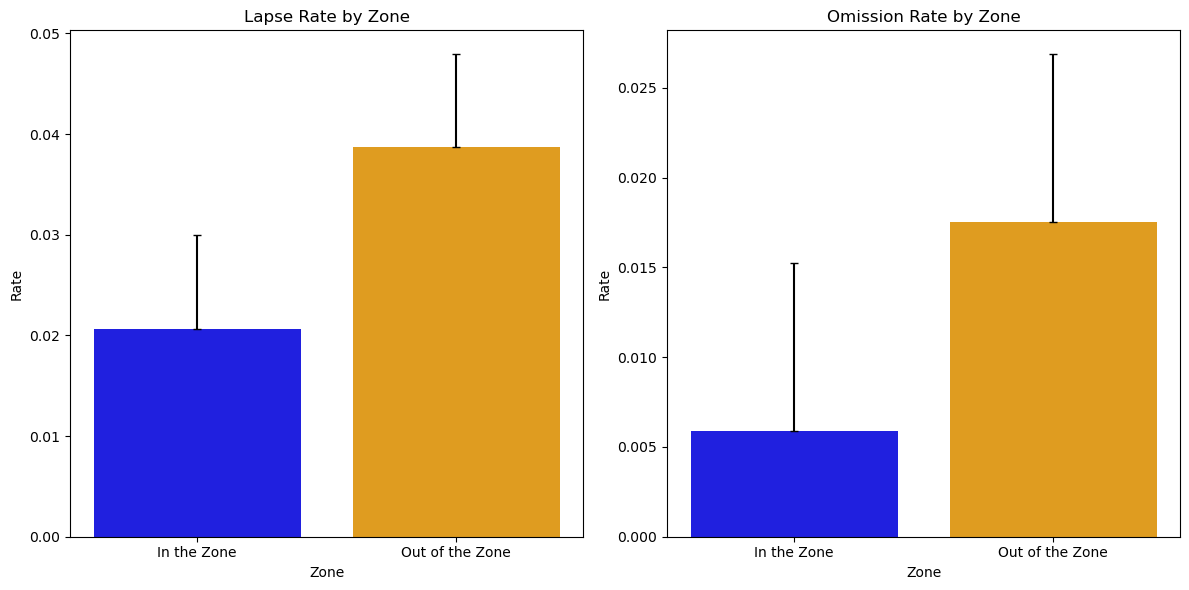

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame (add your DataFrame loading code here)

# Calculate the rates and standard errors for 'Lapse' and 'Omission' conditions by 'Zone'
conditions_of_interest = ['Lapse', 'Omission']
zones = gradcpt_data['Zone'].unique()

# Prepare data for plotting
plot_data = []
for condition in conditions_of_interest:
    for zone in zones:
        subset = gradcpt_data[(gradcpt_data['Condition'] == condition) & (gradcpt_data['Zone'] == zone)]
        rate = len(subset) / len(gradcpt_data[gradcpt_data['Zone'] == zone])
        se = np.sqrt(rate * (1 - rate) / len(subset))  # Binomial standard error
        plot_data.append({'Condition': condition, 'Zone': str(zone), 'Rate': rate, 'SE': se})

plot_df = pd.DataFrame(plot_data)
plot_df['Zone'] = pd.Categorical(plot_df['Zone'], categories=["1", "0"], ordered=True)
plot_df = plot_df.sort_values('Zone')

# Plotting
plt.figure(figsize=(12, 6))
for i, condition in enumerate(conditions_of_interest, 1):
    plt.subplot(1, 2, i)
    ax = sns.barplot(x='Zone', y='Rate', hue='Zone', data=plot_df[plot_df['Condition'] == condition], 
                     errorbar=None, palette={str(1): 'blue', str(0): 'orange'}, legend=False)
    plt.title(f'{condition} Rate by Zone')
    plt.xlabel('Zone')
    plt.ylabel('Rate')
    
    # Correctly placing the error bars, only upper part, without markers
    for index, patch in enumerate(ax.patches):
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        zone = plot_df[(plot_df['Condition'] == condition)]['Zone'].iloc[index]
        se = plot_df[(plot_df['Condition'] == condition) & (plot_df['Zone'] == zone)]['SE'].iloc[0]
        plt.errorbar(x, height, yerr=[[0], [se]], fmt='', color='black', capsize=3)

    # Adjust x-axis labels
    ax.set_xticks([0, 1])  # This ensures that the ticks are indeed where you expect them to be
    ax.set_xticklabels(['In the Zone', 'Out of the Zone'])

plt.tight_layout()
plt.savefig('error_by_zone.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()
